Споздание базы данных, заполнение таблиц из датасета. Написание sql-запросов, использование агрегатных функций. Визуализация данных.

In [1]:
# main.py
import pandas as pd
import numpy as np
import kagglehub
import sys
sys.path.append('/content/sample_data')
import loader_dataset as loader
import mdl_analysis as analysis
import mdl_visualization as visual
import mdl_database as db

# Датасет взят с сайта https://www.kaggle.com/
file_path = "/content/sample_data/titanic.csv"
dataset = loader.load_csv_file(file_path)


Данные успешно загружены.


In [2]:
# Вывод статистической информации
analysis.statistic_data(dataset)

Первые 5 записей:
    Survived  Pclass                                               Name  \
0         0       3                             Mr. Owen Harris Braund   
1         1       1  Mrs. John Bradley (Florence Briggs Thayer) Cum...   
2         1       3                              Miss. Laina Heikkinen   
3         1       1        Mrs. Jacques Heath (Lily May Peel) Futrelle   
4         0       3                            Mr. William Henry Allen   

      Sex   Age  Siblings/Spouses Aboard  Parents/Children Aboard     Fare  
0    male  22.0                        1                        0   7.2500  
1  female  38.0                        1                        0  71.2833  
2  female  26.0                        0                        0   7.9250  
3  female  35.0                        1                        0  53.1000  
4    male  35.0                        0                        0   8.0500  

Последние 5 записей:
      Survived  Pclass                            Na

In [2]:
# Добавление базы данных
name_db = 'titanic.db'
cursor = db.create_db(name_db)

БД titanic.db создана


In [3]:
# Удаление таблиц
tbl_users = 'users'
tbl_tikets = 'tikets'
db.drob_tbl(cursor, tbl_users)
db.drob_tbl(cursor, tbl_tikets)

Таблица users удалена
Таблица tikets удалена


In [4]:
# Создание таблиц
columns_user = '''id INTEGER PRIMARY KEY,
  Survived INTEGER,
  Name TEXT,
  Sex TEXT,
  Age INTEGER,
  Siblings INTEGER,
  Parents INTEGER'''
db.create_tbl(cursor, tbl_users, columns_user)

columns_tiket = '''tiket_class INTEGER,
  Price INTEGER,
  id_user INTEGER PRIMARY KEY'''
db.create_tbl(cursor, tbl_tikets, columns_tiket)



Добавлена таблица users в бд
Добавлена таблица tikets в бд


In [5]:
# Переименуем столбцы в датасете
dataset.rename(columns={'Siblings/Spouses Aboard': 'Siblings',
                        'Parents/Children Aboard': 'Parents',
                        'Fare': 'Price', 'Pclass': 'tiket_class'}, inplace=True)
print(dataset[:3])

   Survived  tiket_class                                               Name  \
0         0            3                             Mr. Owen Harris Braund   
1         1            1  Mrs. John Bradley (Florence Briggs Thayer) Cum...   
2         1            3                              Miss. Laina Heikkinen   

      Sex   Age  Siblings  Parents    Price  
0    male  22.0         1        0   7.2500  
1  female  38.0         1        0  71.2833  
2  female  26.0         0        0   7.9250  


In [6]:
# Добавление данных из датасета в таблицы
dataset_users = dataset[['Survived', 'Name', 'Sex', 'Age', 'Siblings', 'Parents']]
db.load_tbl(name_db, tbl_users, dataset_users)
dataset_tikets = dataset[['tiket_class', 'Price']]
db.load_tbl(name_db, tbl_tikets, dataset_tikets)

Данные добавлены в таблицу users в бд
Данные добавлены в таблицу tikets в бд


In [7]:
# Удаление записи из таблицы
column = 'Age'
value = '= "14.5"'
db.delete_string(cursor, tbl_users, column, value)


Запись в таблице users удалена


In [7]:
# Реализация запросов в бд
# 1
outputs = 'Survived, Name, Age'
condition = 'WHERE Age < 18 AND Parents = 1'
list_children = db.select_tbl(cursor, tbl_users, outputs, condition)
print(f'Список всех детей ({len(list_children)}) с родителями на борту: \n')
for child in list_children:
  if child[0] == 0:
    survived = 'погиб'
  else:
    survived = 'выжил'
  print(f'{child[1]}, возраст: {child[2]} - {survived}')

# 2
outputs = 'COUNT(Age)'
condition = 'WHERE Age < 18'
count_children = db.select_tbl(cursor, tbl_users, outputs, condition)
print(f'Количество детей на борту: {count_children[0][0]}\n')

# 3
outputs = 'COUNT(Sex), Sex'
condition = 'WHERE survived = 0 AND age > 18 GROUP BY sex ORDER BY sex DESC'
count_by_sex = db.select_tbl(cursor, tbl_users, outputs, condition)
print('Количество погибших мужчин и женщин: \n')
for survived in count_by_sex:
  print(f'{survived[0]} - {survived[1]}')

# 4
outputs = 'tiket_class, COUNT(tiket_class), Survived'
condition = f'INNER JOIN {tbl_tikets} ON {tbl_users}.id = {tbl_tikets}.id_user GROUP BY tiket_class, Survived'
survived_by_tiket_class = db.select_tbl(cursor, tbl_users, outputs, condition)
print('Выживаемость по классу билета: \n')
headings_survived = ["Класс", "Количество", "Факт смерти"]
df = pd.DataFrame(survived_by_tiket_class, columns=headings_survived)
print(df)

# 5
outputs = 'tiket_class, AVG(Price), COUNT(Price)'
condition = 'GROUP BY tiket_class'
price_by_class = db.select_tbl(cursor, tbl_tikets, outputs, condition)
print('Средняя стоимость билета по классу: \n')
for price in price_by_class:
  print(f'{price[0]} класс - {round(price[1])} £s Всего {price[2]}')

# 6
outputs = 'SUM(Price)'
condition = ''
count_price = db.select_tbl(cursor, tbl_tikets, outputs, condition)
print(f'Сумма стоимости всех билетов: {round(count_price[0][0])} £s')



Запрос в таблицу users выполнен
Список всех детей (51) с родителями на борту: 

Master. Gosta Leonard Palsson, возраст: 2 - погиб
Miss. Marguerite Rut Sandstrom, возраст: 4 - выжил
Master. Eugene Rice, возраст: 2 - погиб
Miss. Torborg Danira Palsson, возраст: 8 - погиб
Master. Juha Niilo Panula, возраст: 7 - погиб
Master. Gerios Moubarek, возраст: 7 - выжил
Miss. Anna Peter, возраст: 2 - выжил
Master. Eino Viljami Panula, возраст: 1 - погиб
Master. Arthur Rice, возраст: 4 - погиб
Miss. Eleanor Ileen Johnson, возраст: 1 - выжил
Master. Henry Forbes Lefebre, возраст: 5 - погиб
Master. Richard F Becker, возраст: 1 - выжил
Master. Michel M Navratil, возраст: 3 - выжил
Miss. Telma Matilda Strom, возраст: 2 - погиб
Miss. Mathilde Lefebre, возраст: 12 - погиб
Mr. Ernesti Arvid Panula, возраст: 16 - погиб
Master. Eric Rice, возраст: 7 - погиб
Miss. Jean Gertrude Hippach, возраст: 16 - выжил
Master. Edmond Roger Navratil, возраст: 2 - выжил
Master. William Loch Coutts, возраст: 3 - выжил
Mr. T

In [8]:
# Закрытие соединения и сохранение изменений
db.close_connect(name_db)


Соединение с бд titanic.db закрыто


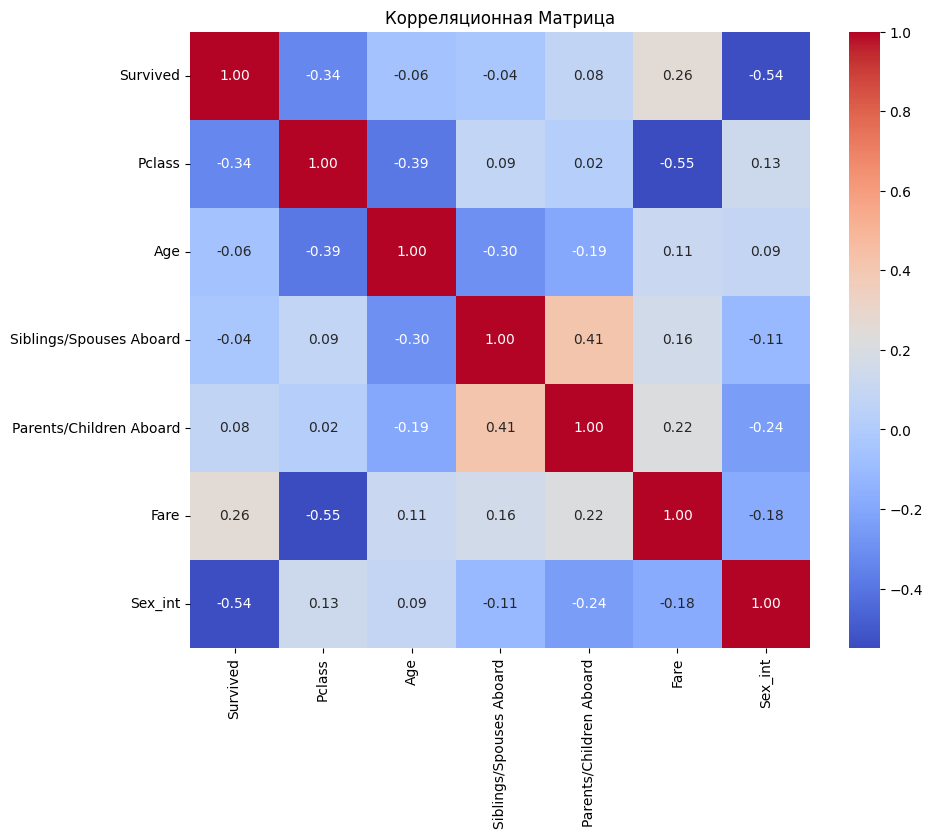

График сохранен: sample_data/outputs_recommend/correlation_matrix.png


In [2]:
# Кодирование категориальных признаков
analysis.encoder_feature(dataset)
# Матрица корреляций
dataset_corr = dataset.drop(['Sex', 'Name'], axis=1)
analysis.corr_data(dataset_corr)

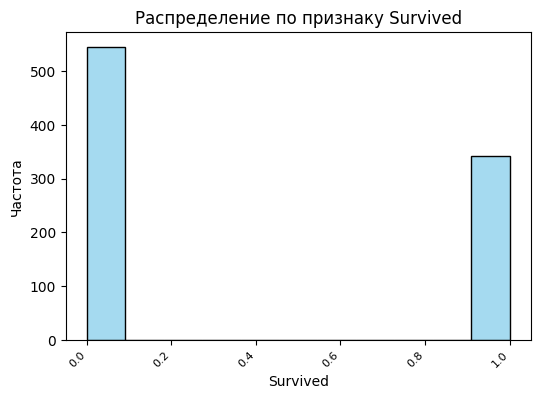

График сохранен: sample_data/outputs/distribution_Survived.png


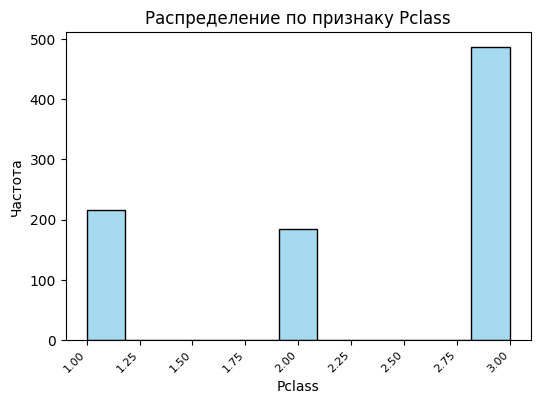

График сохранен: sample_data/outputs/distribution_Pclass.png


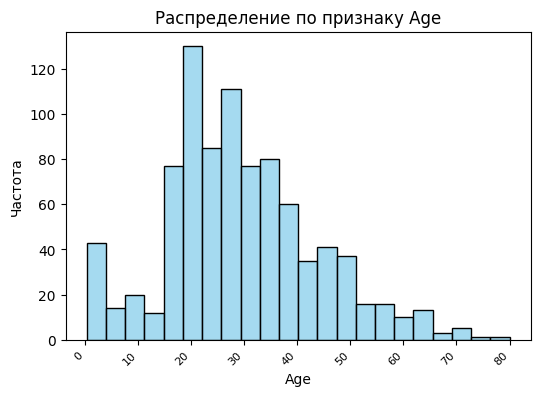

График сохранен: sample_data/outputs/distribution_Age.png


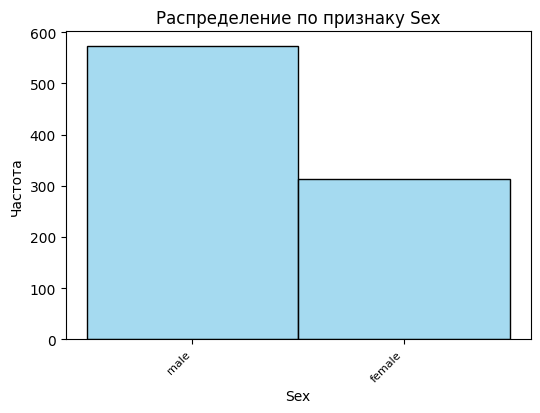

График сохранен: sample_data/outputs/distribution_Sex.png


In [2]:
# Графики распределения по признакам
features = ['Survived', 'Pclass','Age','Sex']
for feature in features:
  visual.visual_distribution(dataset, feature)

График сохранен: sample_data/outputs/survived_by_Pclass.png


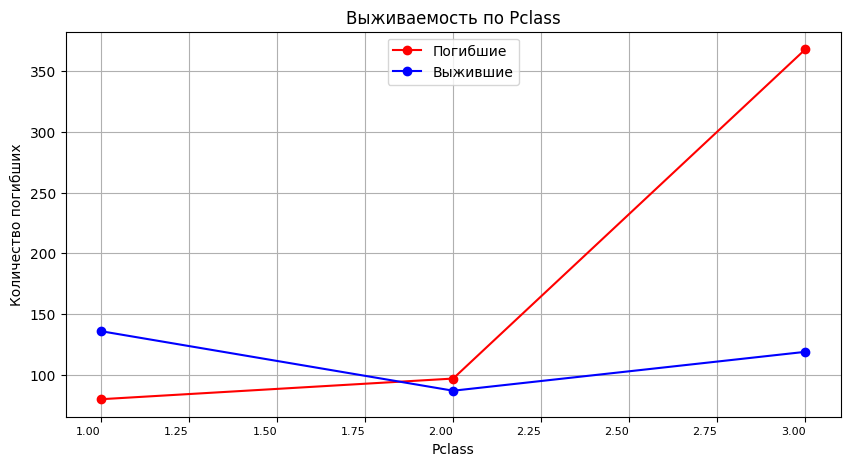

График сохранен: sample_data/outputs/survived_by_Age.png


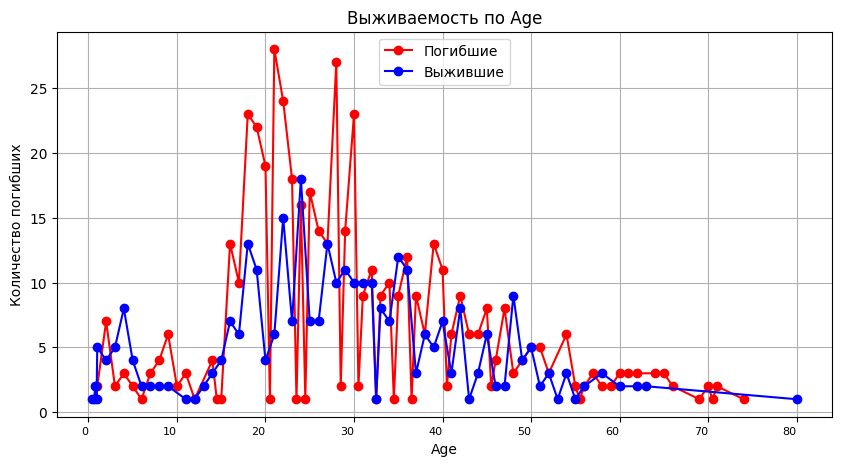

График сохранен: sample_data/outputs/survived_by_Sex.png


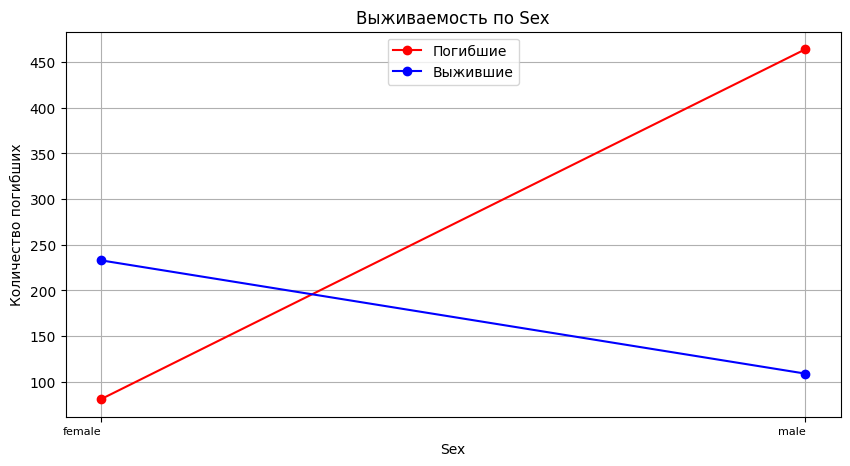

In [2]:
# Линейные графики выживаемости по признакам
features = ['Pclass','Age','Sex']
for feature in features:
  visual.visual_by_survived(dataset, feature)

График сохранен: sample_data/outputs/scatter.png


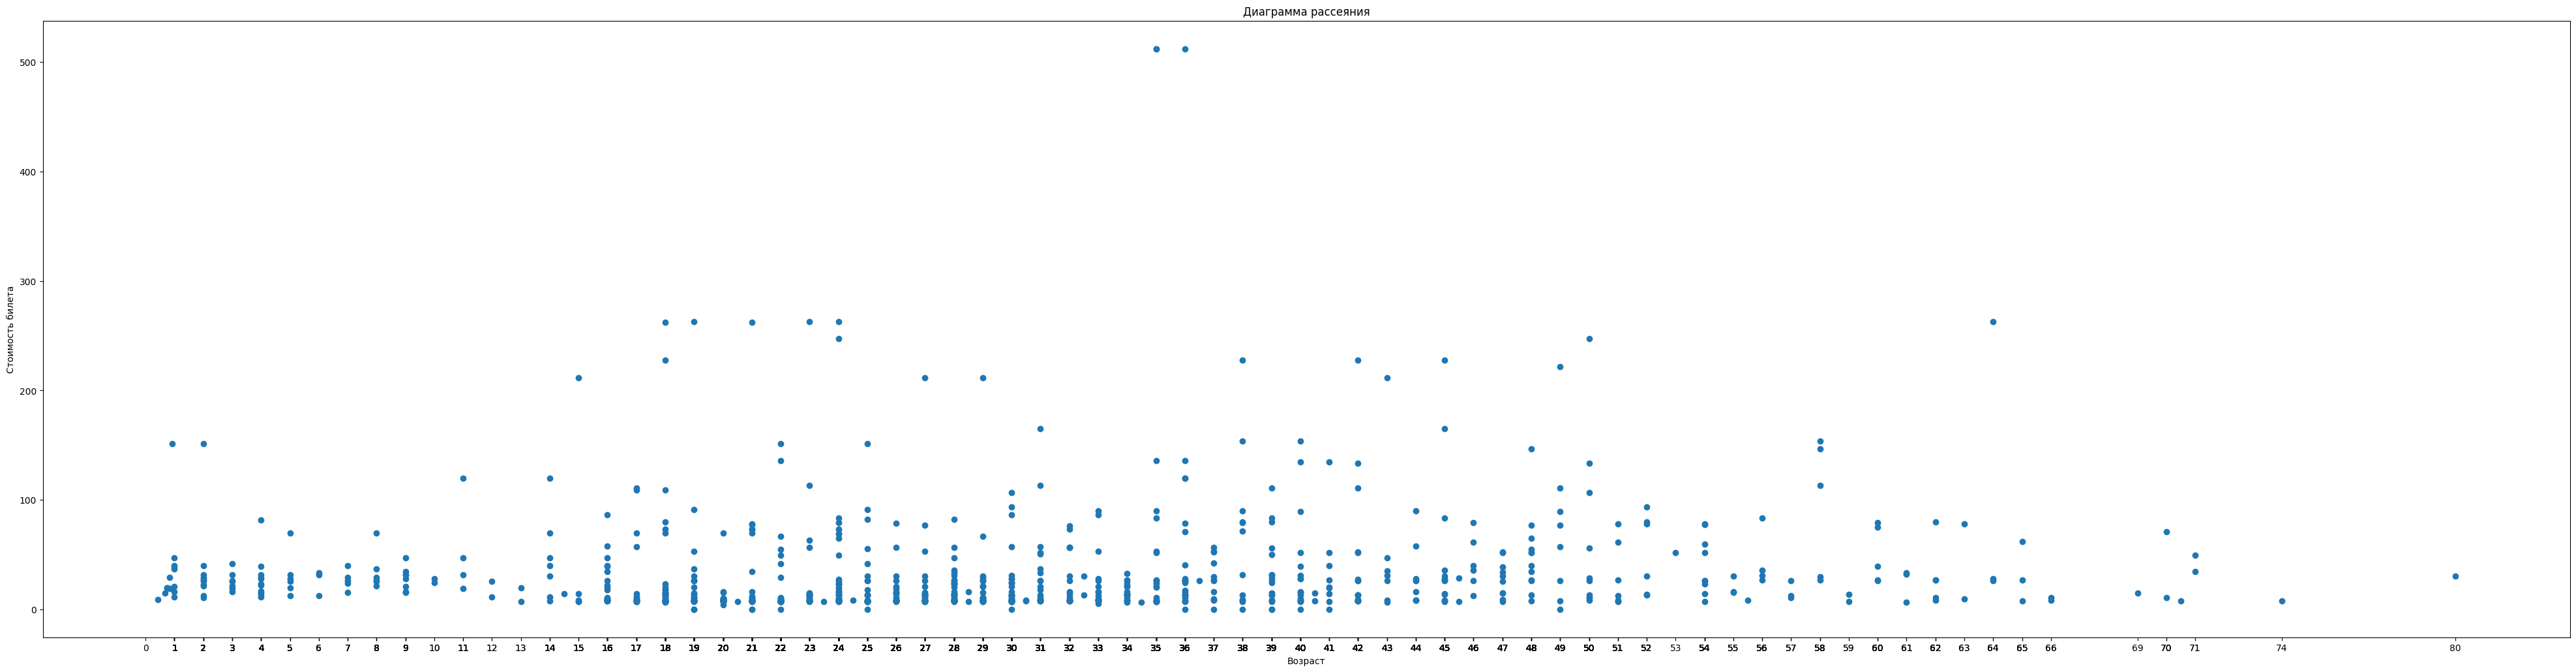

In [2]:
# Диаграмма рассеяния
visual.visual_scatter(dataset)

   Survived  COUNT(tiket_class)
0         0                  80
1         1                 136


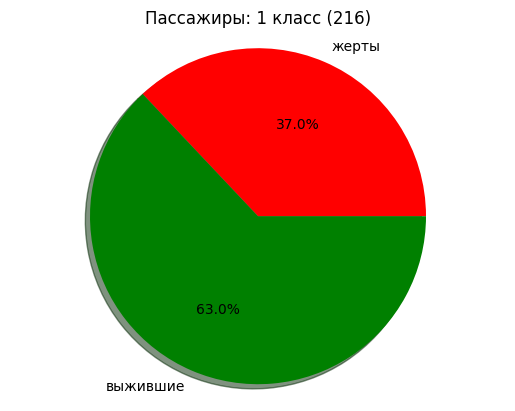

   Survived  COUNT(tiket_class)
0         0                  97
1         1                  87


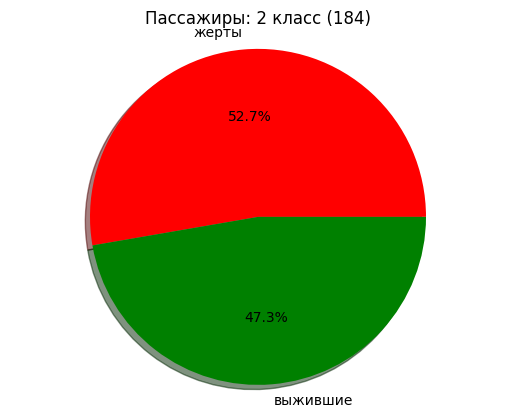

   Survived  COUNT(tiket_class)
0         0                 368
1         1                 119


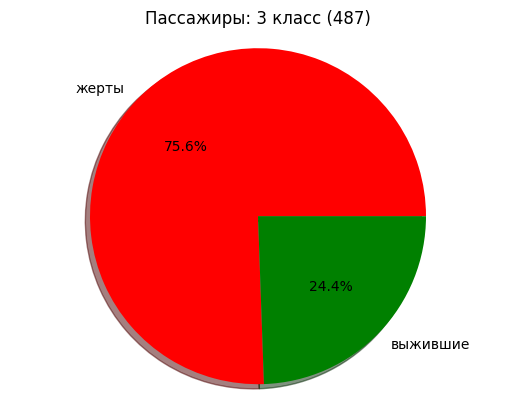

Соединение с бд titanic.db закрыто


In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3

def circle(pass_class):
  outputs = 'Survived, COUNT(tiket_class)'
  condition = f'''INNER JOIN {tbl_tikets} ON {tbl_users}.id = {tbl_tikets}.id_user
  WHERE tiket_class = {pass_class}
  GROUP BY Survived ORDER BY Survived ASC'''
  dataset = pd.read_sql_query(f'SELECT {outputs} FROM {tbl_users} {condition}', conn)
  labels = ["жерты", "выжившие"]
  print(dataset[:3])
  values = dataset["COUNT(tiket_class)"]
  colors = ['red','green']
  plt.pie(values,labels=labels,colors=colors,shadow=True,autopct='%1.1f%%')
  plt.axis('equal')
  plt.title(f"Пассажиры: {pass_class} класс ({dataset['COUNT(tiket_class)'][0] + dataset['COUNT(tiket_class)'][1]})")
  plt.show()

conn = sqlite3.connect('titanic.db')
cursor = conn.cursor()

circle(1)
circle(2)
circle(3)

# Закрытие соединения и сохранение изменений
db.close_connect(name_db)